In [1]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torchvision.io import read_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
class ImageDataset(Dataset):
    def __init__(self,img_folder,transform):
        self.transform=transform
        self.img_folder=img_folder

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)

        return image

In [4]:
training_data = ImageDataset(img_folder='sample_data/img/',transform=Compose([
                                               Resize((32,32)),
                                               ToTensor(),
                                               Normalize(0,1),
                                           ]))
batch_size = 16

train_dataloader = DataLoader(training_data, batch_size = batch_size)

In [5]:
for X in train_dataloader:
    print(X.shape)
    break

torch.Size([16, 3, 32, 32])


In [6]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, num_channel = 3):
        super(Generator, self).__init__()
        self.output_bias = nn.Parameter(torch.zeros(3,img_dim, img_dim), requires_grad = True)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, stride = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(256, 128, 4, stride = 2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, stride = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 4, stride = 2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(32, 32, 5, stride = 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(32, 3, 1, stride = 1, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        z = self.main(z)
        out = z + self.output_bias
        return out

In [8]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(32, 64, 4, stride = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(64, 128, 4, stride = 2,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(128, 256, 4, stride = 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(256, 2*z_dim, 2, stride = 1, bias=True)
        )
    def reparameterize(self, z):
        z = z.view(z.size(0), -1)
        mu, log_sigma = z[:, :self.z_dim], z[:, self.z_dim:]
        std = torch.exp(log_sigma)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        z = self.encoder(x)
        z = self.reparameterize(z)
        return z.view(x.size(0), self.z_dim, 1, 1)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_channel = 3):
        super(Discriminator, self).__init__()
        
        self.conv1x = nn.Conv2d(num_channel, 32, 5, stride = 1, bias=False)
        self.conv2x = nn.Conv2d(32, 64, 4, stride = 2, bias=False)
        self.bn1x = nn.BatchNorm2d(64)
        self.conv3x = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2x =  nn.BatchNorm2d(128)
        self.conv4x = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3x = nn.BatchNorm2d(256)
        self.conv5x = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4x = nn.BatchNorm2d(512)
        
        self.conv1z = nn.Conv2d(z_dim, 512, 1, stride = 1, bias=False)
        self.conv2z = nn.Conv2d(512, 512, 1, stride = 1, bias=False)
        
        self.conv1xz = nn.Conv2d(1024, 1024, 1, stride = 1, bias=False)
        self.conv2xz = nn.Conv2d(1024, 1024, 1, stride = 1, bias=False)
        self.conv3xz = nn.Conv2d(1024, 1, 1, stride = 1, bias=False)
       
    def forward(self, x, z):
        x = F.leaky_relu(self.conv1x(x), negative_slope = 0.2)
        x = F.leaky_relu(self.bn1x(self.conv2x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn2x(self.conv3x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn3x(self.conv4x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn4x(self.conv5x(x)), negative_slope = 0.2)
       
        z = F.leaky_relu(self.conv1z(z), negative_slope = 0.2)
        z = F.leaky_relu(self.conv2z(z), negative_slope = 0.2)
    
        xz = torch.cat((x,z), dim = 1)
        
        xz = F.leaky_relu(self.conv1xz(xz), negative_slope = 0.2)
        xz = F.leaky_relu(self.conv2xz(xz), negative_slope = 0.2)
        xz = F.leaky_relu(self.conv3xz(xz), negative_slope = 0.2)
        
        return torch.sigmoid(xz)

In [10]:
z_dim = 100
img_dim = 32

g = Generator(z_dim, img_dim).to(device)
e = Encoder(z_dim).to(device)
d = Discriminator().to(device)

g.apply(weights_init)
e.apply(weights_init)
d.apply(weights_init)

Discriminator(
  (conv1x): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2x): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (bn1x): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3x): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2x): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4x): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3x): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5x): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4x): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1z): Conv2d(100, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2z): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv1xz): Conv2d(1024, 1024, kernel_size=(1, 

In [11]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

lr = 1e-4
beta1 = 0.5

ge_param = list(g.parameters())+list(e.parameters())

opt_ge = optim.Adam(ge_param, lr = lr,  betas=(beta1, 0.999))
opt_d = optim.Adam(d.parameters(), lr = lr,  betas=(beta1, 0.999))

In [12]:
def plot_img(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))

    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

[1] D Loss : 0.77884 GE Loss : 4.42998


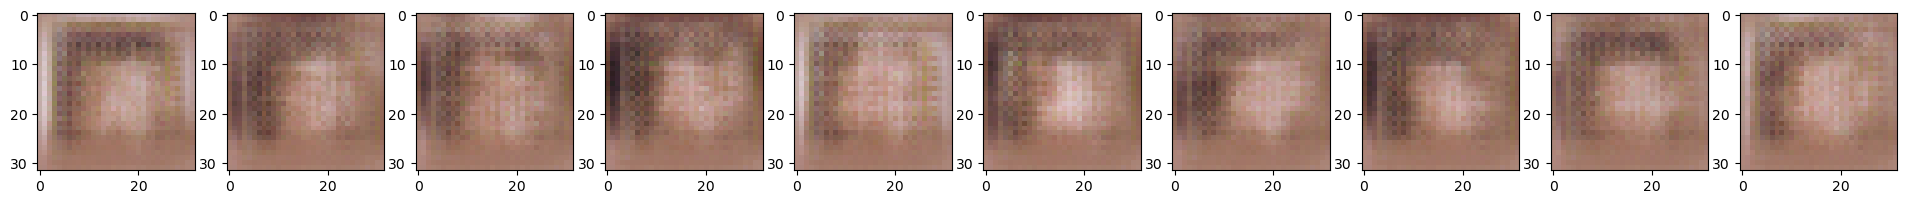

[2] D Loss : 0.78613 GE Loss : 5.93688
[3] D Loss : 0.93947 GE Loss : 4.53244
[4] D Loss : 1.13399 GE Loss : 3.24066
[5] D Loss : 1.06961 GE Loss : 3.29065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6] D Loss : 0.93854 GE Loss : 3.99763


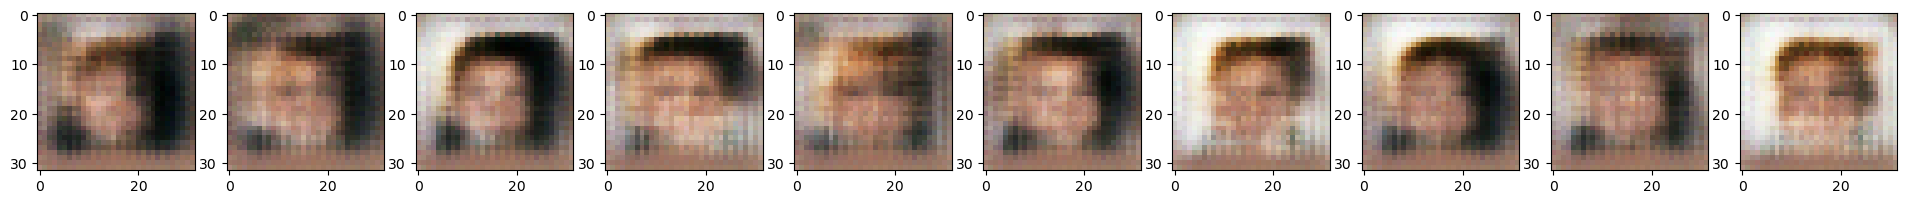

[7] D Loss : 1.03738 GE Loss : 3.40080
[8] D Loss : 1.06999 GE Loss : 3.37256
[9] D Loss : 1.09682 GE Loss : 3.22467
[10] D Loss : 1.14141 GE Loss : 2.87120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[11] D Loss : 1.17487 GE Loss : 2.67187


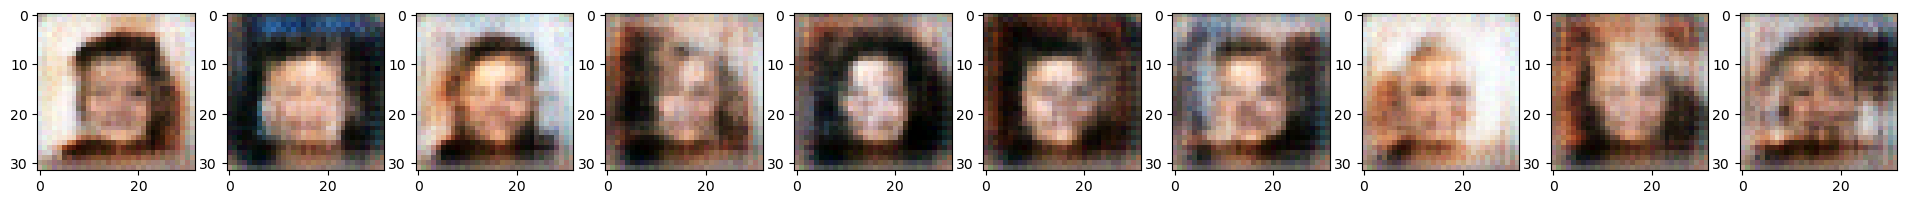

[12] D Loss : 1.18474 GE Loss : 2.56636
[13] D Loss : 1.11227 GE Loss : 2.90520
[14] D Loss : 1.19981 GE Loss : 2.54575
[15] D Loss : 1.15582 GE Loss : 2.67865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[16] D Loss : 1.13165 GE Loss : 2.74762


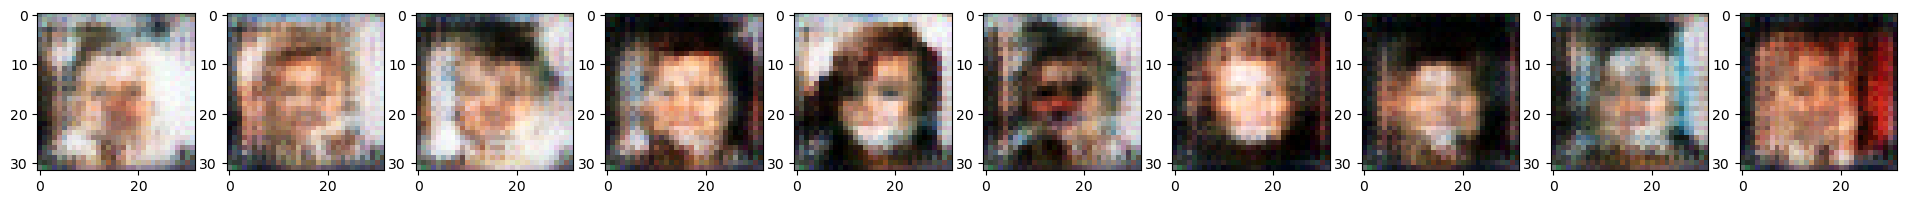

[17] D Loss : 1.06258 GE Loss : 3.19587
[18] D Loss : 1.18984 GE Loss : 3.03345
[19] D Loss : 1.17383 GE Loss : 3.00571
[20] D Loss : 1.16268 GE Loss : 2.79653


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21] D Loss : 1.05219 GE Loss : 3.25744


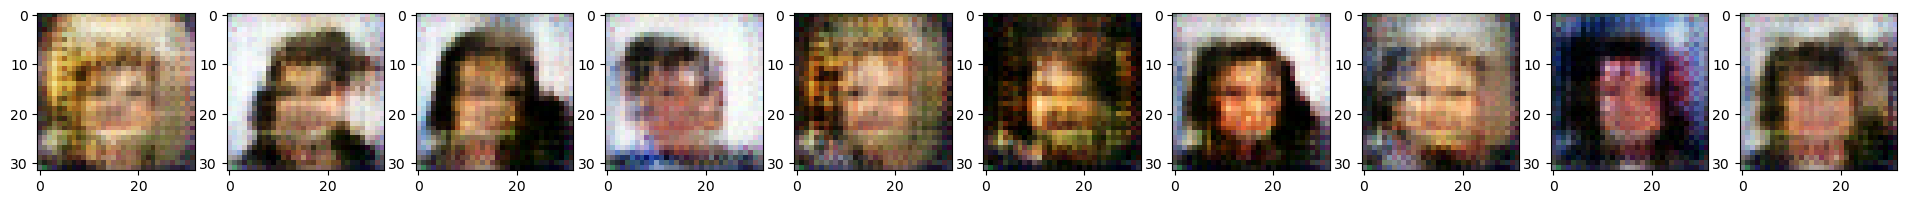

[22] D Loss : 1.06352 GE Loss : 3.38211
[23] D Loss : 1.07631 GE Loss : 3.25252
[24] D Loss : 1.05864 GE Loss : 3.31135
[25] D Loss : 1.06941 GE Loss : 3.33209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[26] D Loss : 1.04281 GE Loss : 3.40121


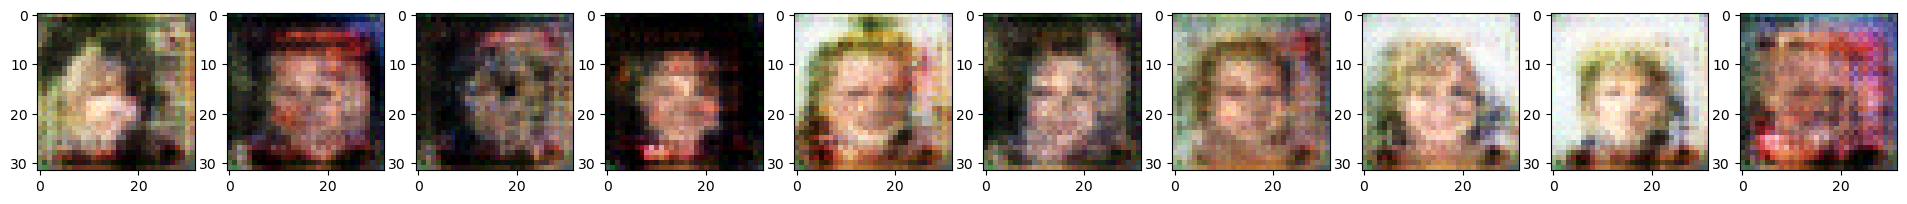

[27] D Loss : 1.01114 GE Loss : 3.64438
[28] D Loss : 1.02015 GE Loss : 3.54765
[29] D Loss : 0.99143 GE Loss : 3.75665
[30] D Loss : 0.96167 GE Loss : 4.01904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[31] D Loss : 0.95225 GE Loss : 3.96798


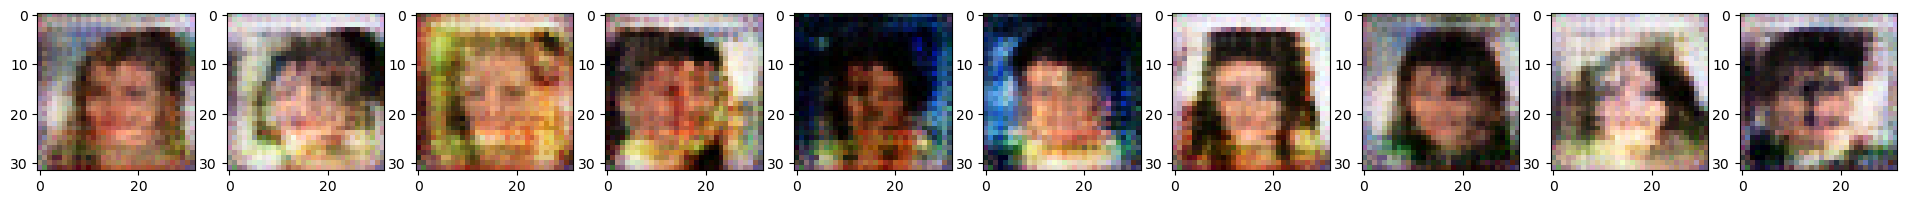

[32] D Loss : 0.90445 GE Loss : 4.28513
[33] D Loss : 0.90268 GE Loss : 4.37824
[34] D Loss : 0.79861 GE Loss : 4.84698
[35] D Loss : 0.76885 GE Loss : 5.47954


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[36] D Loss : 0.78545 GE Loss : 5.11739


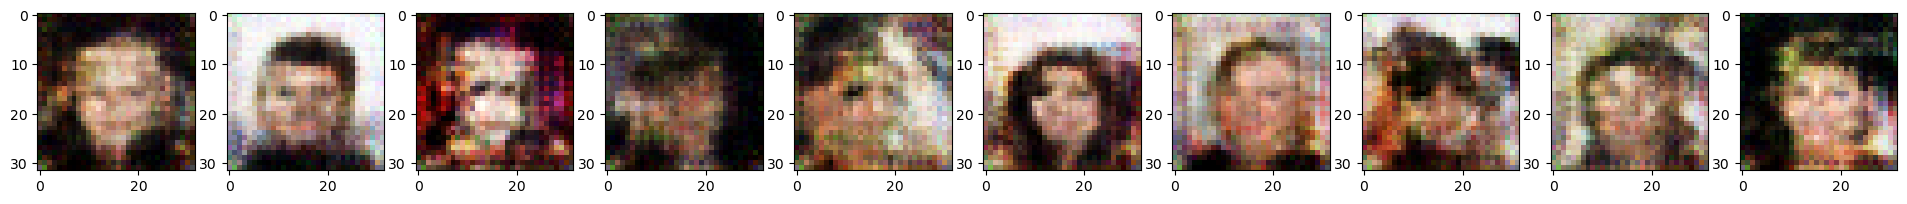

[37] D Loss : 0.74674 GE Loss : 5.41565
[38] D Loss : 0.72633 GE Loss : 5.62081
[39] D Loss : 0.70367 GE Loss : 5.75892
[40] D Loss : 0.65258 GE Loss : 6.25481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[41] D Loss : 0.63736 GE Loss : 6.43404


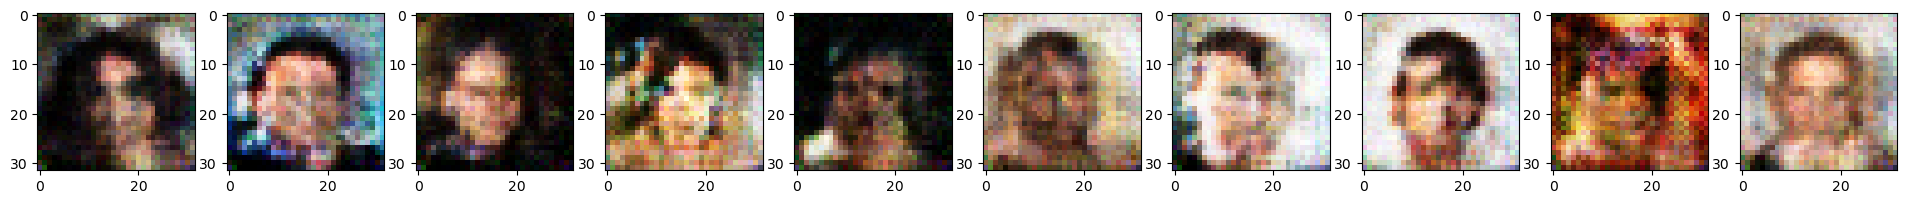

[42] D Loss : 0.59373 GE Loss : 6.91128
[43] D Loss : 0.57820 GE Loss : 6.94263
[44] D Loss : 0.53239 GE Loss : 7.58009
[45] D Loss : 0.51128 GE Loss : 7.83505


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[46] D Loss : 0.51179 GE Loss : 7.93754


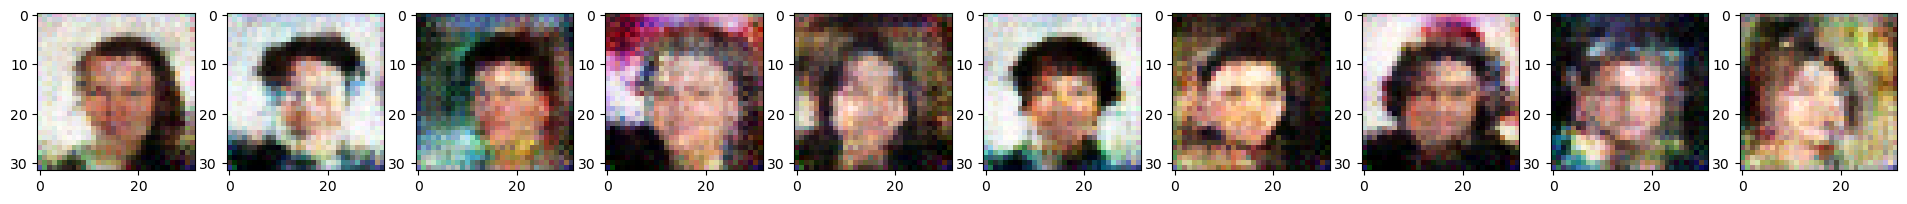

[47] D Loss : 0.47806 GE Loss : 7.94964
[48] D Loss : 0.43707 GE Loss : 8.63636
[49] D Loss : 0.41464 GE Loss : 8.99561
[50] D Loss : 0.42578 GE Loss : 8.80745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[51] D Loss : 0.37169 GE Loss : 9.58459


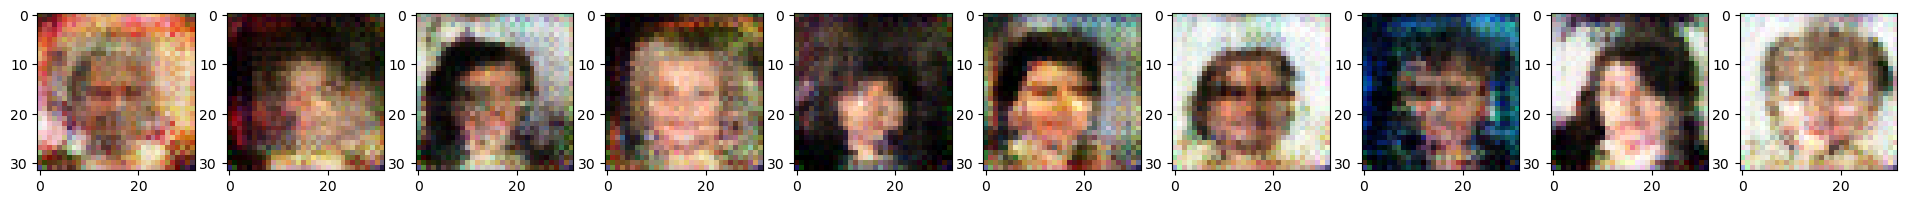

[52] D Loss : 0.38087 GE Loss : 9.61698
[53] D Loss : 0.38850 GE Loss : 10.22284
[54] D Loss : 0.35006 GE Loss : 10.22847
[55] D Loss : 0.35753 GE Loss : 10.12122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[56] D Loss : 0.34152 GE Loss : 10.18673


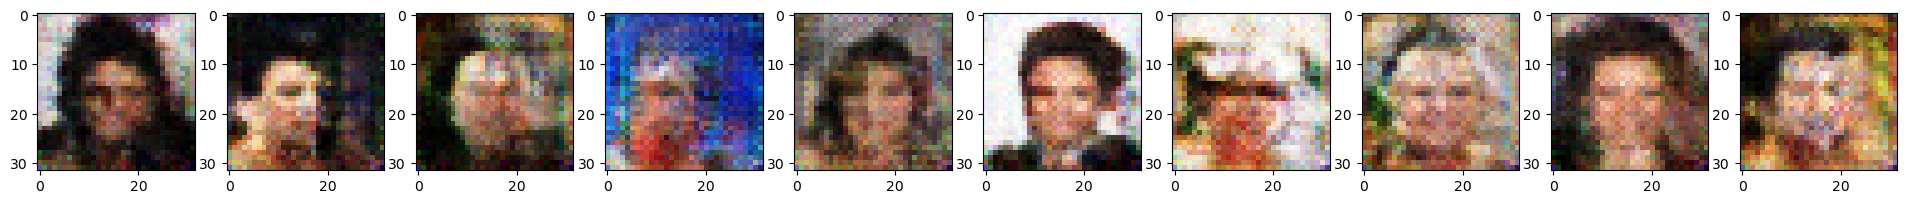

[57] D Loss : 0.29135 GE Loss : 11.25684
[58] D Loss : 0.33067 GE Loss : 11.15879
[59] D Loss : 0.34597 GE Loss : 10.72775
[60] D Loss : 0.30016 GE Loss : 10.81567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[61] D Loss : 0.27426 GE Loss : 11.87048


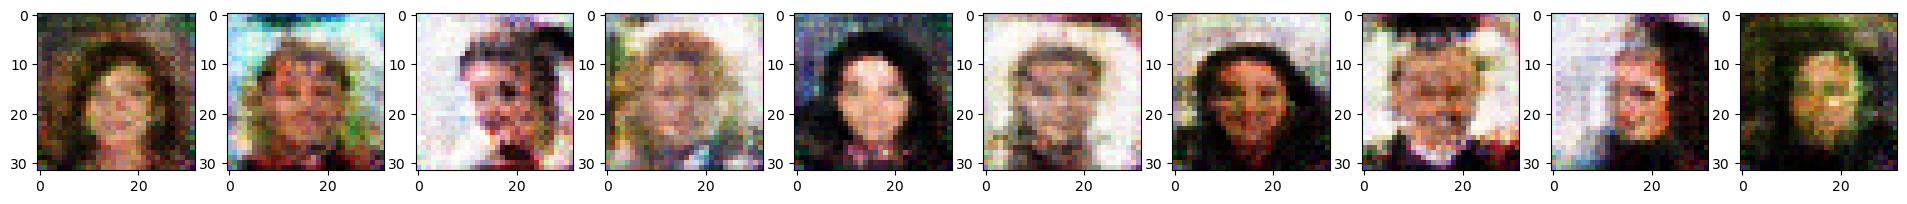

[62] D Loss : 0.28948 GE Loss : 11.44623
[63] D Loss : 0.27708 GE Loss : 12.26112
[64] D Loss : 0.24701 GE Loss : 12.56664
[65] D Loss : 0.29781 GE Loss : 12.87354


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[66] D Loss : 0.25397 GE Loss : 12.86088


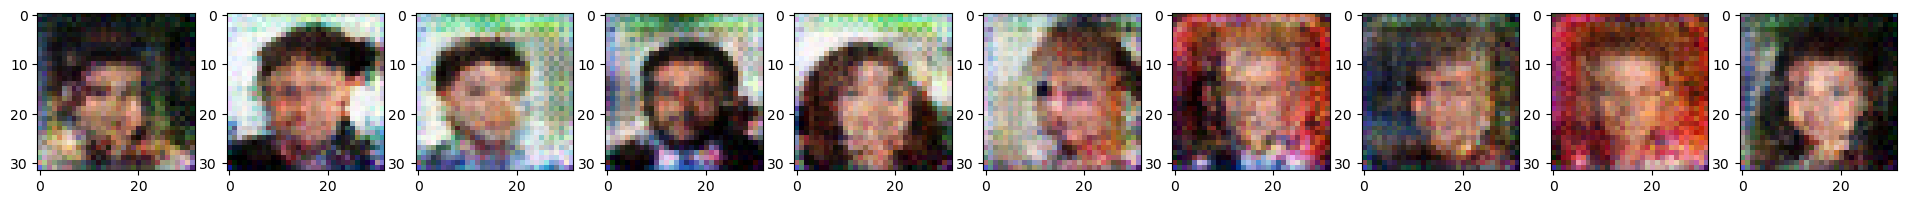

[67] D Loss : 0.25983 GE Loss : 13.02714
[68] D Loss : 0.25492 GE Loss : 13.72647
[69] D Loss : 0.24961 GE Loss : 13.48446
[70] D Loss : 0.22963 GE Loss : 12.98121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[71] D Loss : 0.23525 GE Loss : 13.38707


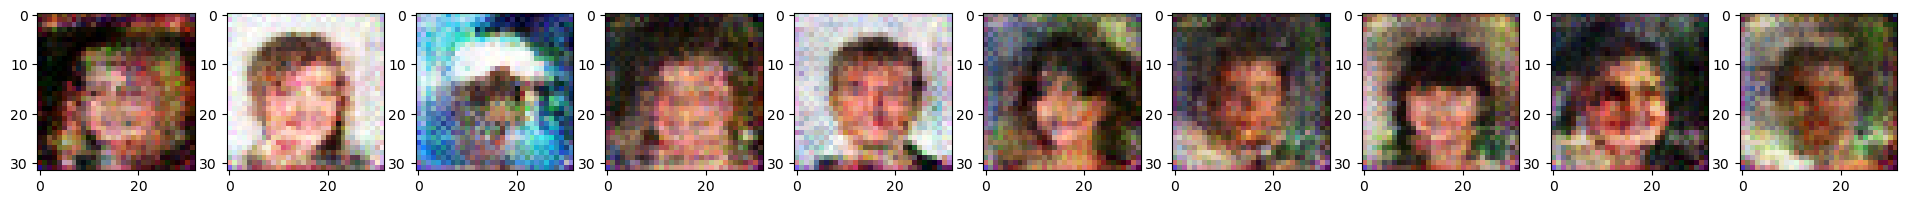

[72] D Loss : 0.21506 GE Loss : 14.20915
[73] D Loss : 0.25200 GE Loss : 14.22900
[74] D Loss : 0.21144 GE Loss : 13.57335
[75] D Loss : 0.21091 GE Loss : 15.38010


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[76] D Loss : 0.18647 GE Loss : 14.92591


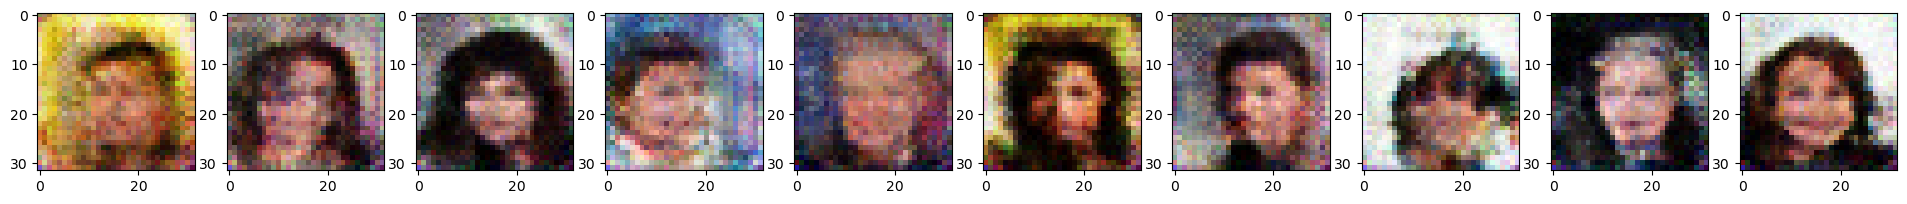

[77] D Loss : 0.16821 GE Loss : 16.40304
[78] D Loss : 0.23896 GE Loss : 16.38863
[79] D Loss : 0.20235 GE Loss : 16.22038
[80] D Loss : 0.19694 GE Loss : 15.73167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[81] D Loss : 0.17860 GE Loss : 16.75653


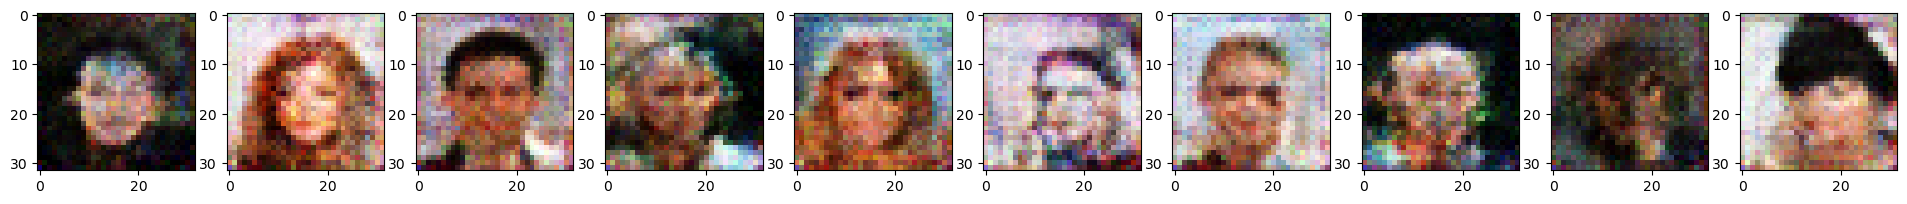

[82] D Loss : 0.17920 GE Loss : 17.94942
[83] D Loss : 0.17191 GE Loss : 18.56794
[84] D Loss : 0.17740 GE Loss : 17.60759
[85] D Loss : 0.18883 GE Loss : 17.54466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[86] D Loss : 0.17217 GE Loss : 18.53164


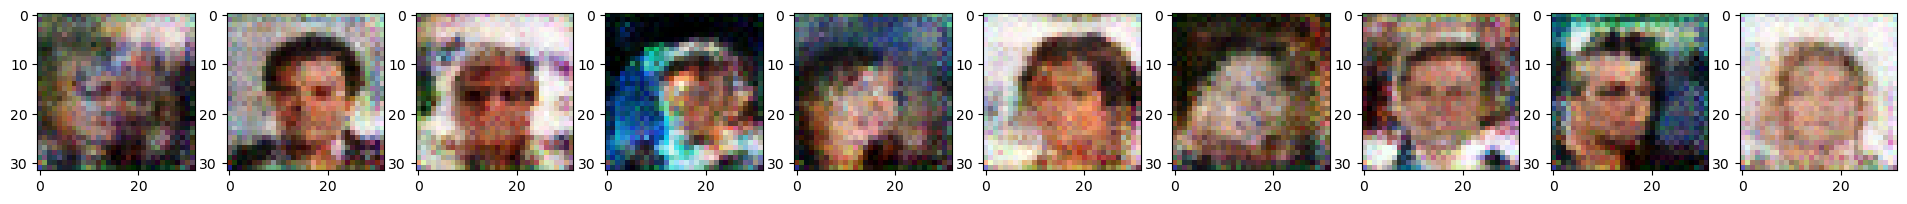

[87] D Loss : 0.17844 GE Loss : 16.98807
[88] D Loss : 0.16434 GE Loss : 18.30680
[89] D Loss : 0.18348 GE Loss : 18.15275
[90] D Loss : 0.15088 GE Loss : 18.85269


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[91] D Loss : 0.12647 GE Loss : 20.17615


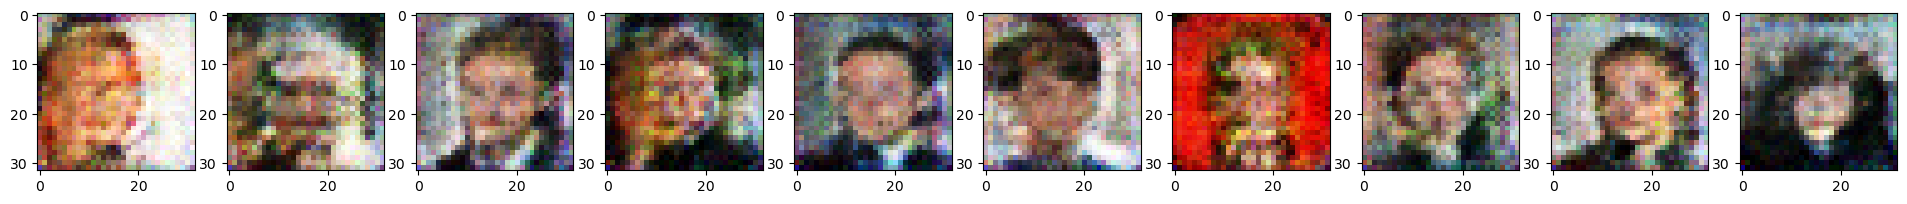

[92] D Loss : 0.20355 GE Loss : 19.38784
[93] D Loss : 0.13648 GE Loss : 20.72629
[94] D Loss : 0.17486 GE Loss : 19.71112
[95] D Loss : 0.15680 GE Loss : 20.33392


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[96] D Loss : 0.15564 GE Loss : 20.13332


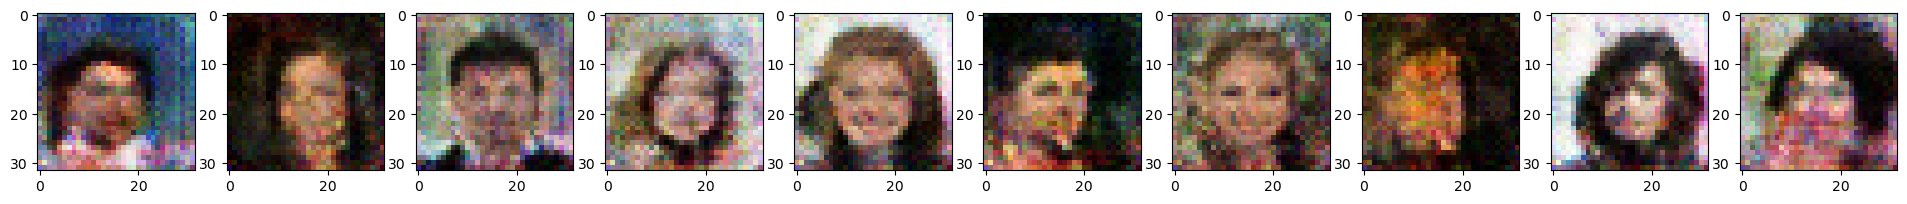

[97] D Loss : 0.17578 GE Loss : 20.47206
[98] D Loss : 0.13600 GE Loss : 21.34433
[99] D Loss : 0.16998 GE Loss : 22.34174
[100] D Loss : 0.18405 GE Loss : 20.07418


In [13]:
epochs = 100
num_steps = len(train_dataloader.dataset)//batch_size

clip_value = 1.2

for epoch in tqdm(range(epochs)):
    ge_loss, d_loss = 0, 0
    for step, (X) in enumerate(train_dataloader):
        X = X.to(device)
        y_true = Variable(torch.ones(X.size(0),1, dtype=torch.float).to(device), requires_grad = False)
        y_fake = Variable(torch.zeros(X.size(0), 1, dtype=torch.float).to(device), requires_grad = False)
        
        noise1 = Variable(torch.Tensor(X.size()).normal_(0, 0.1 * (epochs - epoch) / epochs),requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(X.size()).normal_(0, 0.1 * (epochs - epoch) / epochs),requires_grad=False).to(device)
   
        ######## TRAINING DISCRIMINATOR ###########
        opt_d.zero_grad()

        z_fake = Variable(torch.randn((X.size(0), z_dim, 1, 1)).to(device), requires_grad = False)
        x_fake = g(z_fake)

        z_true = e(X)

        out_true = d(X+noise1, z_true).view(X.shape[0],-1)
        out_fake = d(x_fake+noise2, z_fake).view(X.shape[0],-1)

        loss_d = criterion(out_true, y_true) + criterion(out_fake, y_fake)
        loss_d.backward()
        nn.utils.clip_grad_value_(d.parameters(), clip_value)
        opt_d.step()
            
        ######## TRAINING GENERATOR AND ENCODER PART ###########
            
        opt_ge.zero_grad()
            
        z_fake = Variable(torch.randn((X.size(0), z_dim, 1, 1)).to(device), requires_grad = False)
        x_fake = g(z_fake)

        z_true = e(X)

        out_true = d(X+noise1, z_true).view(X.shape[0],-1)
        out_fake = d(x_fake+noise2, z_fake).view(X.shape[0],-1)
            
        loss_ge = criterion(out_fake, y_true) + criterion(out_true, y_fake)
        loss_ge.backward()
        nn.utils.clip_grad_value_(ge_param, clip_value)
        opt_ge.step()
            
        ge_loss += loss_ge.item()
        d_loss += loss_d.item()
            
    print(f"[{epoch+1}] D Loss : {d_loss/num_steps:>.5f} GE Loss : {ge_loss/num_steps:>.5f}")
    if epoch % 5 == 0:
        z_fake = torch.randn((X.size(0), z_dim, 1, 1)).to(device)
        plot_img(g(z_fake)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


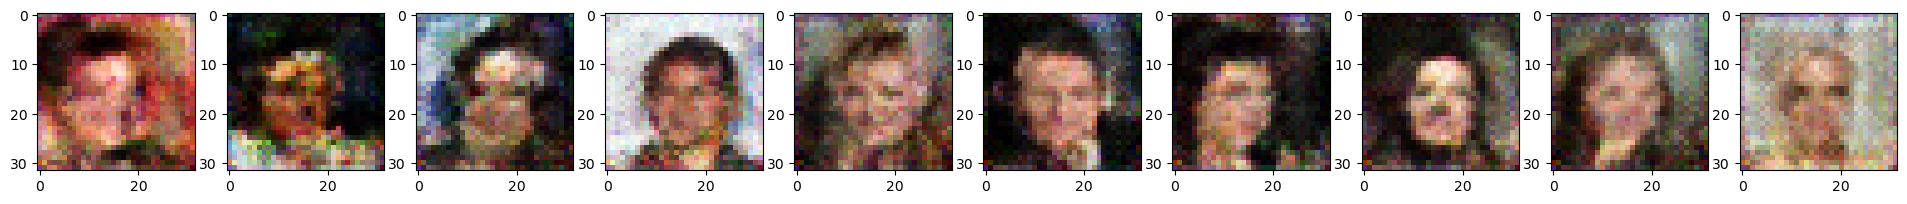

In [14]:
z_fake = torch.randn((X.size(0), z_dim, 1, 1)).to(device)
plot_img(g(z_fake))